<a href="https://colab.research.google.com/github/vinayjoshva/Colab-PyTorch-NeuralNetwork/blob/main/Practical_4_(16352584).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd

# Load the dataset
file_path = "Mens Fashion.csv"  # Update this path as needed
df = pd.read_csv(file_path)

# Display the first few rows to inspect the structure
print(df.head())

                                                name main_category  \
0                        Sparx mens Sd9039g Sneakers        stores   
1  WildHorn Brown RFID Blocking Leather Wallet fo...        stores   
2  Casio Vintage Series Digital Grey Dial Men's W...        stores   
3  SJeware Men & Women Solid Ankle Length Socks (...        stores   
4  Fashion Frill Men's Double Coated Popular Stai...        stores   

    sub_category                                              image  \
0  Men's Fashion  https://m.media-amazon.com/images/I/51e48JV2Gf...   
1  Men's Fashion  https://m.media-amazon.com/images/I/81vMec1lk+...   
2  Men's Fashion  https://m.media-amazon.com/images/I/61ybeKQto8...   
3  Men's Fashion  https://m.media-amazon.com/images/I/61r8Z4tDkv...   
4  Men's Fashion  https://m.media-amazon.com/images/I/61cY9DOK2X...   

                                                link ratings no_of_ratings  \
0  https://www.amazon.in/Sparx-Casual-Stripped-Sn...     4.0         1,893

In [7]:
# Selecting relevant features
features = ["ratings", "no_of_ratings", "discount_price", "actual_price"]
df_selected = df[features].copy()

In [8]:
# Function to clean and convert columns to numeric
def clean_numeric(column):
    return pd.to_numeric(column.astype(str).str.replace(r"[^\d.]", "", regex=True), errors='coerce')

# Apply the function to clean and convert numeric columns
df_selected["no_of_ratings"] = clean_numeric(df_selected["no_of_ratings"])
df_selected["discount_price"] = clean_numeric(df_selected["discount_price"])
df_selected["actual_price"] = clean_numeric(df_selected["actual_price"])
df_selected["ratings"] = pd.to_numeric(df_selected["ratings"], errors='coerce')  # Convert ratings to float

# Fill missing values with median
df_selected.fillna(df_selected.median(), inplace=True)

# Display cleaned data
print(df_selected.head())

   ratings  no_of_ratings  discount_price  actual_price
0      4.0         1893.0           499.0         999.0
1      4.0        33466.0           285.0        1499.0
2      4.4        29931.0           524.0        1695.0
3      3.3         1212.0           145.0         399.0
4      4.1          721.0           179.0         998.0


In [9]:
# Filling missing values with median
df_selected.fillna(df_selected.median(), inplace=True)

In [10]:
from sklearn.preprocessing import MinMaxScaler

# Initialize the scaler
scaler = MinMaxScaler()

# Fit and transform the data
df_scaled = scaler.fit_transform(df_selected)

# Convert back to DataFrame
df_scaled = pd.DataFrame(df_scaled, columns=features)


In [11]:
import numpy as np

sequence_length = 5  # Number of past observations to consider

# Creating sequences
X, y = [], []
for i in range(len(df_scaled) - sequence_length):
    X.append(df_scaled.iloc[i:i+sequence_length].values)  # Past 'sequence_length' records
    y.append(df_scaled.iloc[i+sequence_length].values)    # Next value

# Convert lists to NumPy arrays
X = np.array(X)
y = np.array(y)

print(f"Input Shape: {X.shape}, Target Shape: {y.shape}")


Input Shape: (19195, 5, 4), Target Shape: (19195, 4)


In [12]:
import torch

# Convert data into PyTorch tensors
X_tensor = torch.tensor(X, dtype=torch.float32)
y_tensor = torch.tensor(y, dtype=torch.float32)

print(f"Tensor Shape - X: {X_tensor.shape}, y: {y_tensor.shape}")


Tensor Shape - X: torch.Size([19195, 5, 4]), y: torch.Size([19195, 4])


#Defining RNN

In [13]:
import torch.nn as nn

class RNNModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNNModel, self).__init__()
        self.hidden_size = hidden_size
        self.rnn = nn.RNN(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out, _ = self.rnn(x)
        out = self.fc(out[:, -1, :])  # Take only the last output
        return out


In [20]:
import matplotlib.pyplot as plt

def train_model_with_tracking(model, X_train, y_train, epochs=20, learning_rate=0.001):
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    losses = []  # Store loss per epoch

    for epoch in range(epochs):
        optimizer.zero_grad()
        outputs = model(X_train)
        loss = criterion(outputs, y_train)
        loss.backward()
        optimizer.step()

        losses.append(loss.item())  # Track loss

        if (epoch + 1) % 5 == 0:
            print(f"Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.6f}")

    return model, losses


In [21]:
input_size = 4  # Number of features
hidden_size = 64  # Can be adjusted
output_size = 4  # Number of output features

rnn_model = RNNModel(input_size, hidden_size, output_size)
rnn_model = train_model(rnn_model, X_tensor, y_tensor)

Epoch [5/20], Loss: 0.078839
Epoch [10/20], Loss: 0.021689
Epoch [15/20], Loss: 0.010343
Epoch [20/20], Loss: 0.010645


#LSTM Model

In [16]:
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.fc(out[:, -1, :])  # Take only the last output
        return out


In [17]:
lstm_model = LSTMModel(input_size, hidden_size, output_size)
lstm_model = train_model(lstm_model, X_tensor, y_tensor)


Epoch [5/20], Loss: 0.153927
Epoch [10/20], Loss: 0.124686
Epoch [15/20], Loss: 0.095247
Epoch [20/20], Loss: 0.063355


#GRU Model

In [18]:
class GRUModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(GRUModel, self).__init__()
        self.hidden_size = hidden_size
        self.gru = nn.GRU(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out, _ = self.gru(x)
        out = self.fc(out[:, -1, :])  # Take only the last output
        return out


In [19]:
gru_model = GRUModel(input_size, hidden_size, output_size)
gru_model = train_model(gru_model, X_tensor, y_tensor)


Epoch [5/20], Loss: 0.068079
Epoch [10/20], Loss: 0.039998
Epoch [15/20], Loss: 0.018890
Epoch [20/20], Loss: 0.007150


In [22]:
rnn_model, rnn_losses = train_model_with_tracking(RNNModel(input_size, hidden_size, output_size), X_tensor, y_tensor)
lstm_model, lstm_losses = train_model_with_tracking(LSTMModel(input_size, hidden_size, output_size), X_tensor, y_tensor)
gru_model, gru_losses = train_model_with_tracking(GRUModel(input_size, hidden_size, output_size), X_tensor, y_tensor)


Epoch [5/20], Loss: 0.083585
Epoch [10/20], Loss: 0.015870
Epoch [15/20], Loss: 0.013533
Epoch [20/20], Loss: 0.011312
Epoch [5/20], Loss: 0.097388
Epoch [10/20], Loss: 0.071531
Epoch [15/20], Loss: 0.046051
Epoch [20/20], Loss: 0.021654
Epoch [5/20], Loss: 0.127189
Epoch [10/20], Loss: 0.087772
Epoch [15/20], Loss: 0.053674
Epoch [20/20], Loss: 0.025445


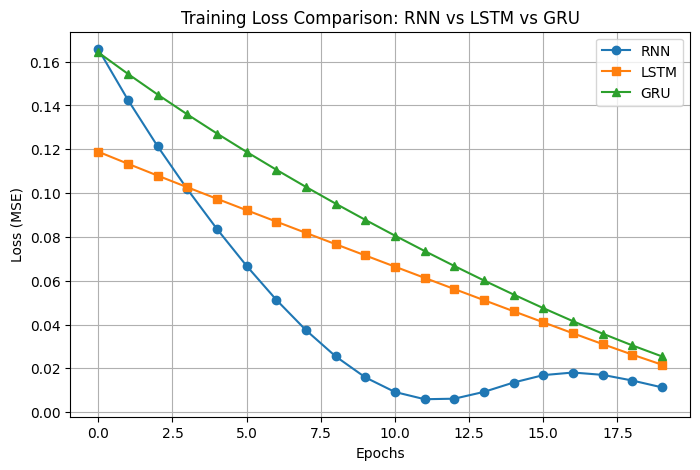

In [23]:
plt.figure(figsize=(8, 5))

plt.plot(rnn_losses, label="RNN", marker="o")
plt.plot(lstm_losses, label="LSTM", marker="s")
plt.plot(gru_losses, label="GRU", marker="^")

plt.xlabel("Epochs")
plt.ylabel("Loss (MSE)")
plt.title("Training Loss Comparison: RNN vs LSTM vs GRU")
plt.legend()
plt.grid(True)
plt.show()


In [24]:
pip install transformers


In [2]:
from transformers import pipeline

# Load a better model (GPT-2)
explainer = pipeline("text-generation", model="gpt2")

# Define new prompts
prompts = [
    "Why does RNN perform worse than LSTM and GRU in sequential data processing?",
    "Why does LSTM handle long-term dependencies better than RNN?",
    "Why does GRU train faster than LSTM while maintaining similar performance?"
]

# Generate explanations
for prompt in prompts:
    explanation = explainer(prompt, max_length=100, truncation=True)
    print(f"\nPrompt: {prompt}\nExplanation: {explanation[0]['generated_text']}")


config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Device set to use cpu
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.



Prompt: Why does RNN perform worse than LSTM and GRU in sequential data processing?
Explanation: Why does RNN perform worse than LSTM and GRU in sequential data processing? I'll explain.

LSTM¶ RNN uses LSTM as the primary processor, a fast, multi-core CPU running on an OS system with three or four CPU cores. LSTM uses most of the CPU's data, and in some cases not all. LSTM also has some memory requirements, which means it may be slower in certain performance scenarios. LSTM can


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.



Prompt: Why does LSTM handle long-term dependencies better than RNN?
Explanation: Why does LSTM handle long-term dependencies better than RNN?

As mentioned above, RNN is a framework for developing distributed learning and modeling systems, so in LSTM the state of the art is quite high. As such, it does not mean the most elegant and reliable RNN or even RNN for short term data storage, where there are high costs of parallelizing and scaling the entire dataset into a single package (but it does help with that task!).



Prompt: Why does GRU train faster than LSTM while maintaining similar performance?
Explanation: Why does GRU train faster than LSTM while maintaining similar performance? Did this happen because of my training schedule? And does a training cycle lead to a better performance? So which is the better training? The GRU test is easy to apply and simple to use. (I will do a detailed analysis later)

Why I didn't have a LSTM at the time

My girlfriend had an anxiety attack fro